In [17]:
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import pprint
import os
from shutil import copyfile
from tqdm.notebook import tqdm
import pandas as pd
import h5py
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

from skimage.util import img_as_float, img_as_ubyte
from skimage.color import rgb2gray
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import unsharp_mask
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank

In [18]:
img_dir = Path('./data/MoNuSeg Training Data/TissueImages')
annotation_dir = Path('./data/MoNuSeg Training Data/Annotations')
coordinate_dir = Path('./data/MoNuSeg Training Data/xy')
os.makedirs(coordinate_dir, exist_ok = True)

micai_data_path = Path('./data/micai_data.h5')
grayscale_micai_data_path = Path('./data/grayscale_micai_data.h5')


In [3]:
annotation_file = os.listdir(annotation_dir)
print(annotation_file)

['TCGA-38-6178-01Z-00-DX1.xml', 'TCGA-HE-7129-01Z-00-DX1.xml', 'TCGA-A7-A13E-01Z-00-DX1.xml', 'TCGA-HE-7128-01Z-00-DX1.xml', 'TCGA-G9-6356-01Z-00-DX1.xml', 'TCGA-AY-A8YK-01A-01-TS1.xml', 'TCGA-NH-A8F7-01A-01-TS1.xml', 'TCGA-G2-A2EK-01A-02-TSB.xml', 'TCGA-HE-7130-01Z-00-DX1.xml', 'TCGA-DK-A2I6-01A-01-TS1.xml', 'TCGA-A7-A13F-01Z-00-DX1.xml', 'TCGA-E2-A1B5-01Z-00-DX1.xml', 'TCGA-G9-6348-01Z-00-DX1.xml', 'TCGA-G9-6336-01Z-00-DX1.xml', 'TCGA-AR-A1AS-01Z-00-DX1.xml', 'TCGA-CH-5767-01Z-00-DX1.xml', 'TCGA-49-4488-01Z-00-DX1.xml', 'TCGA-21-5784-01Z-00-DX1.xml', 'TCGA-B0-5710-01Z-00-DX1.xml', 'TCGA-50-5931-01Z-00-DX1.xml', 'TCGA-B0-5711-01Z-00-DX1.xml', 'TCGA-E2-A14V-01Z-00-DX1.xml', 'TCGA-KB-A93J-01A-01-TS1.xml', 'TCGA-RD-A8N9-01A-01-TS1.xml', 'TCGA-AR-A1AK-01Z-00-DX1.xml', 'TCGA-G9-6362-01Z-00-DX1.xml', 'TCGA-G9-6363-01Z-00-DX1.xml', 'TCGA-B0-5698-01Z-00-DX1.xml', 'TCGA-18-5592-01Z-00-DX1.xml', 'TCGA-21-5786-01Z-00-DX1.xml', 'TCGA-2Z-A9J9-01A-01-TS1.xml', 'TCGA-44-2665-01B-06-BS6.xml', 'TCGA-6

In [4]:
for name in tqdm(annotation_file, total=len(annotation_file)):
    file = annotation_dir / name
    root = ET.parse(file).getroot()
    centroids = []
    for type_tag in root.findall('Annotation/Regions/Region'):
        x_sum = []
        y_sum = []
        for coord in type_tag.findall('Vertices/Vertex'):
            x, y = coord.attrib['X'], coord.attrib['Y']
            x_sum.append(float(x))
            y_sum.append(float(y))
        
        x_avg = int(np.mean(x_sum))
        y_avg = int(np.mean(y_sum))
        
        centroids.append([x_avg, y_avg])
    
    centroids = np.array(centroids)
    df = pd.DataFrame()
    df['x'] = centroids[:, 0]
    df['y'] = centroids[:, 1]
    
    df.to_csv(coordinate_dir / '{}.csv'.format(name.split('.')[0]))

In [19]:
img_list = os.listdir(img_dir)
img_list.sort()
xy_list = os.listdir(coordinate_dir)
xy_list.sort()

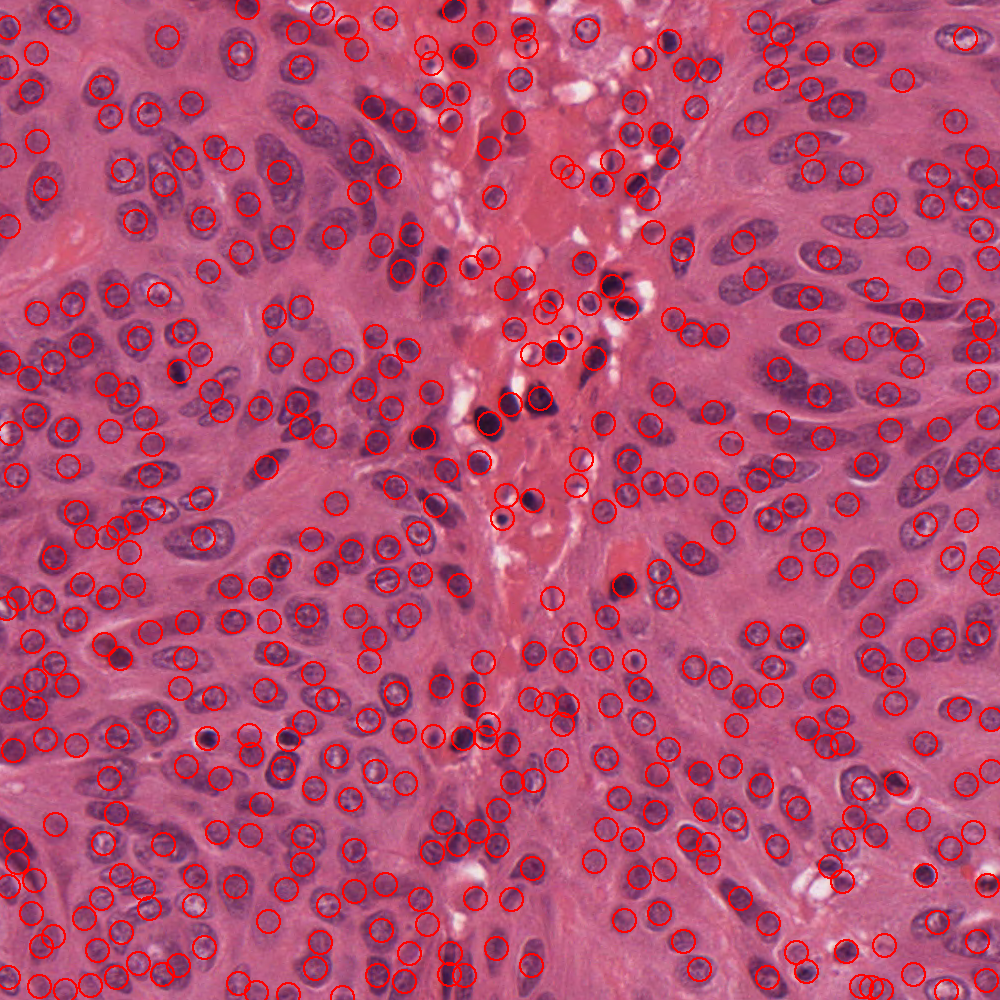

In [20]:
for img_file in img_list:
    name = img_file.split('.')[0]
    img = Image.open(img_dir / img_file)
    df = pd.read_csv(coordinate_dir / '{}.csv'.format(name))
    coords = df[['x', 'y']].values
    
    draw = ImageDraw.Draw(img)
    size = 12
    for coord in coords:
        draw.ellipse([coord[0] - size,
                      coord[1] - size,
                      coord[0] + size,
                      coord[1] + size], outline=(255,0,0), width=2)
    display(img)
    break
    

In [21]:
def generate_diffusion(max_size):
    g_range = 2
    X,Y=np.meshgrid(np.linspace(-g_range,g_range,max_size),np.linspace(-g_range,g_range,max_size));
    mu,sigma=0,1;
    G=np.exp(-((X-mu)**2+(Y-mu)**2)/2.0*sigma**2)
    
#     plt.contourf(X, Y, G, 100, cmap='Blues')
#     plt.colorbar()
#     plt.show()
    
    return G / np.max(G.flatten())

def generate_difusion_map(xy_coord, size, max_distance):
    additional_width = int(size * 0.2)
    max_size = size + 2*additional_width
    img_arr = np.full((max_size, max_size), 0.0)
    diff_arr = generate_diffusion(max_distance)
    diff_distance = int(np.floor(diff_arr.shape[0]/2.))
    
    for i in xy_coord:
        y = int(i[0] + additional_width)
        x = int(i[1] + additional_width)
        temp_arr = img_arr[x - diff_distance: x + diff_distance + 1, y - diff_distance: y + diff_distance + 1]
        temp_arr = np.maximum(temp_arr, diff_arr)
        img_arr[x - diff_distance: x + diff_distance + 1, y - diff_distance: y + diff_distance + 1] = temp_arr
        
    return img_arr[additional_width: additional_width + size, additional_width: additional_width + size]
    
    

In [22]:
with h5py.File(micai_data_path, 'w') as file:
    for i in tqdm(range(len(img_list))):
        print(img_list[i])
        name, ext = img_list[i].split('.')[0], img_list[i].split('.')[1]

            
        img = Image.open(img_dir / '{}.{}'.format(name, ext))
        img_arr = np.array(img)
        
        df = pd.read_csv(coordinate_dir / '{}.csv'.format(name), index_col=0)
        coords = df[['x', 'y']].values

        pmap_arr = generate_difusion_map(coords, img.size[0], 25)
#         print(np.max(pmap_arr), pmap_arr.shape)
        
        file.create_dataset('img/{:03d}'.format(i), data=img_arr)
        file.create_dataset('pmap/{:03d}'.format(i), data=pmap_arr)
        file.create_dataset('xy/{:03d}'.format(i), data=coords)


TCGA-18-5592-01Z-00-DX1.png
TCGA-21-5784-01Z-00-DX1.png
TCGA-21-5786-01Z-00-DX1.png
TCGA-38-6178-01Z-00-DX1.png
TCGA-44-2665-01B-06-BS6.png
TCGA-49-4488-01Z-00-DX1.png
TCGA-50-5931-01Z-00-DX1.png
TCGA-69-7764-01A-01-TS1.png
TCGA-A6-6782-01A-01-BS1.png
TCGA-A7-A13E-01Z-00-DX1.png
TCGA-A7-A13F-01Z-00-DX1.png
TCGA-AC-A2FO-01A-01-TS1.png
TCGA-AO-A0J2-01A-01-BSA.png
TCGA-AR-A1AK-01Z-00-DX1.png
TCGA-AR-A1AS-01Z-00-DX1.png
TCGA-AY-A8YK-01A-01-TS1.png
TCGA-B0-5698-01Z-00-DX1.png
TCGA-B0-5710-01Z-00-DX1.png
TCGA-B0-5711-01Z-00-DX1.png
TCGA-CH-5767-01Z-00-DX1.png
TCGA-CU-A0YN-01A-02-BSB.png
TCGA-DK-A2I6-01A-01-TS1.png
TCGA-E2-A14V-01Z-00-DX1.png
TCGA-E2-A1B5-01Z-00-DX1.png
TCGA-EJ-A46H-01A-03-TSC.png
TCGA-FG-A4MU-01B-01-TS1.png
TCGA-G2-A2EK-01A-02-TSB.png
TCGA-G9-6336-01Z-00-DX1.png
TCGA-G9-6348-01Z-00-DX1.png
TCGA-G9-6356-01Z-00-DX1.png
TCGA-G9-6362-01Z-00-DX1.png
TCGA-G9-6363-01Z-00-DX1.png
TCGA-GL-6846-01A-01-BS1.png
TCGA-HC-7209-01A-01-TS1.png
TCGA-HE-7128-01Z-00-DX1.png
TCGA-HE-7129-01Z-00-

1.0 (1000, 1000) (1000, 1000)


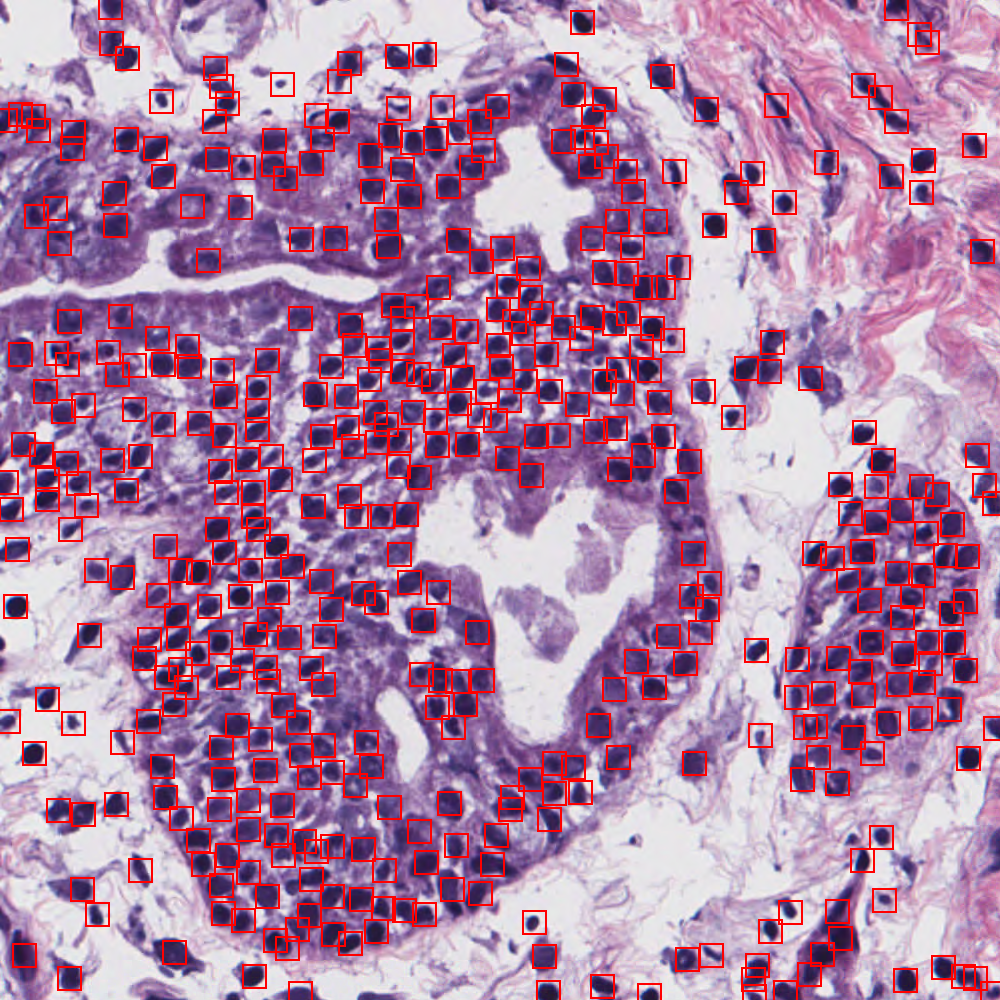

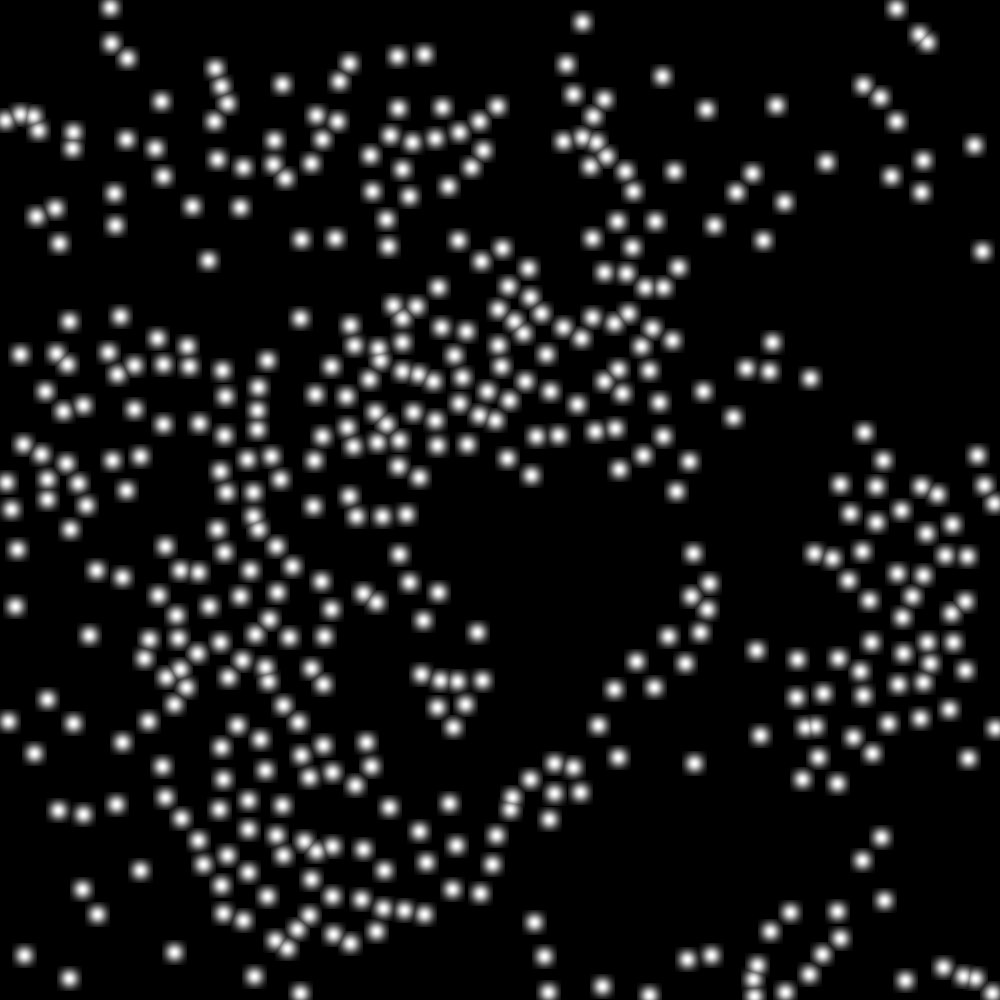

In [23]:
sample_num = np.random.randint(low=0, high=len(img_list))
with h5py.File(micai_data_path, 'r') as file:
    img = Image.fromarray(file.get('img/{:03d}'.format(sample_num))[:])
    pmap = file.get('pmap/{:03d}'.format(sample_num))[:]
    coords = file.get('xy/{:03d}'.format(sample_num))[:]
    
    print(np.max(pmap), pmap_img.size, img.size)

    pmap *= (255./np.max(pmap))
    pmap_img = Image.fromarray(pmap.astype('uint8'), 'L')
    
    
    draw = ImageDraw.Draw(img)
    size = 12
    for coord in coords:
        draw.rectangle([coord[0] - size,
                        coord[1] - size,
                        coord[0] + size,
                        coord[1] + size], outline=(255,0,0), width=2)

    display(img)
    display(pmap_img)
    pmap_img.save("./test.png")
